In [2]:
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.preprocessing import image
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D,Dropout,Input
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.models import Sequential,Model
from keras import backend as K
from IPython.display import display
import matplotlib.pyplot as plt

In [3]:
base_model  = InceptionV3(weights = 'imagenet', include_top=False)
print('loaded model')

loaded model


In [4]:
# Data Preprocessing
data_gen_args = dict(preprocessing_function=preprocess_input, #Define the dictionary for Image data Generator
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_datagen = image.ImageDataGenerator(**data_gen_args)
test_datagen = image.ImageDataGenerator(**data_gen_args)

In [5]:
# Loading Images 
train_generator = train_datagen.flow_from_directory("Data/train",
                                                    target_size=(299,299),batch_size=32)

valid_generator = test_datagen.flow_from_directory("Data/test",
                                                     target_size=(299,299),batch_size=32)

Found 706 images belonging to 3 classes.
Found 227 images belonging to 3 classes.


In [43]:
# Benchmark Model
# Define the model architecture

from keras.layers import Conv2D,MaxPooling2D,Flatten

benchmark = Sequential()
benchmark.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (299,299,3)))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
benchmark.add(MaxPooling2D(pool_size=2,padding='same'))
benchmark.add(Dropout(0.3))
benchmark.add(Flatten())
benchmark.add(Dense(512, activation='relu'))
benchmark.add(Dropout(0.5))
benchmark.add(Dense(3, activation='softmax'))

benchmark.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 299, 299, 16)      208       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 150, 150, 32)      2080      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 75, 75, 64)        8256      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 38, 64)       

In [44]:
# Compile
benchmark.compile(loss = 'categorical_crossentropy',optimizer='rmsprop', metrics = ['accuracy'])

In [45]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('saved_model/benchmark.hdf5', verbose=1,save_best_only=True)
# Stop the training if the model shows no improvement  
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=0,verbose=1,mode='auto')

In [63]:
# Train the model
history = benchmark.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=3, epochs=15,verbose=1,callbacks=[checkpointer])

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.9758 - accuracy: 0.5959
Epoch 00001: val_loss did not improve from 1.05107
13/13 [==============================] - 24s 2s/step - loss: 0.9758 - accuracy: 0.5959 - val_loss: 1.3939 - val_accuracy: 0.3750
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7308
Epoch 00002: val_loss did not improve from 1.05107
13/13 [==============================] - 25s 2s/step - loss: 0.7126 - accuracy: 0.7308 - val_loss: 1.5145 - val_accuracy: 0.4375
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7409
Epoch 00003: val_loss did not improve from 1.05107
13/13 [==============================] - 23s 2s/step - loss: 0.6761 - accuracy: 0.7409 - val_loss: 1.5966 - val_accuracy: 0.4062
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7812
Epoch 00004: val_loss did not improve from 1.05107
13/13 [==========================

In [64]:
# Transfer Learning
# Define the output layers for Inceptionv3
last = base_model.output
x = GlobalAveragePooling2D()(last)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(3,activation='softmax')(x)

model = Model(base_model.input,preds)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [65]:
### Loading weights of benchmark model
#Load the weights for the common layers from the benchmark model
base_model.load_weights(filepath='saved_model/benchmark.hdf5',by_name=True)

In [66]:
#Freeze the original layers of Inception3
for layer in base_model.layers:
    layer.trainable = False

In [67]:
#Compile the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

In [68]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

# Save the model with best weights
checkpointer = ModelCheckpoint('saved_model/transfer_learning.hdf5', verbose=1,save_best_only=True)
# Stop the traning if the model shows no improvement
stopper = EarlyStopping(monitor='val_loss',min_delta=0.1,patience=1,verbose=1,mode='auto')

In [69]:
# Train the model
history_transfer = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=4, epochs=15,verbose=1,callbacks=[checkpointer])

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.8740 - accuracy: 0.6442
Epoch 00001: val_loss improved from inf to 1.48363, saving model to saved_model\transfer_learning.hdf5
13/13 [==============================] - 32s 2s/step - loss: 0.8740 - accuracy: 0.6442 - val_loss: 1.4836 - val_accuracy: 0.4766
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.5047 - accuracy: 0.8293
Epoch 00002: val_loss did not improve from 1.48363
13/13 [==============================] - 31s 2s/step - loss: 0.5047 - accuracy: 0.8293 - val_loss: 1.7264 - val_accuracy: 0.5078
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.4617 - accuracy: 0.8173
Epoch 00003: val_loss did not improve from 1.48363
13/13 [==============================] - 29s 2s/step - loss: 0.4617 - accuracy: 0.8173 - val_loss: 2.1127 - val_accuracy: 0.4297
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8446
Epoch 00004: val_loss did not im

In [71]:
# training metrics values
display(history_transfer.history)

{'loss': [0.8740417957305908,
  0.504713237285614,
  0.4616548717021942,
  0.4063103199005127,
  0.3455084562301636,
  0.24280506372451782,
  0.22911328077316284,
  0.2379775494337082,
  0.22885531187057495,
  0.20473220944404602,
  0.19995421171188354,
  0.19623713195323944,
  0.17340964078903198,
  0.2780964970588684,
  0.2794228196144104],
 'accuracy': [0.6442307829856873,
  0.8293269276618958,
  0.817307710647583,
  0.8445596098899841,
  0.8605769276618958,
  0.9196891188621521,
  0.9145077466964722,
  0.9145077466964722,
  0.9038461446762085,
  0.9119170904159546,
  0.9378238320350647,
  0.9378238320350647,
  0.9378238320350647,
  0.8756476640701294,
  0.893782377243042],
 'val_loss': [1.4836310148239136,
  1.7264091968536377,
  2.1126856803894043,
  1.9859414100646973,
  1.3417391777038574,
  1.12547767162323,
  1.5273513793945312,
  1.423946738243103,
  2.071272850036621,
  1.7491528987884521,
  1.4227420091629028,
  2.1586198806762695,
  2.350538492202759,
  1.3817771673202515,

In [72]:
# Graph
def graph():
    plt.plot(history_transfer.history['accuracy'])
    plt.plot(history_transfer.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history_transfer.history['loss'])
    plt.plot(history_transfer.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

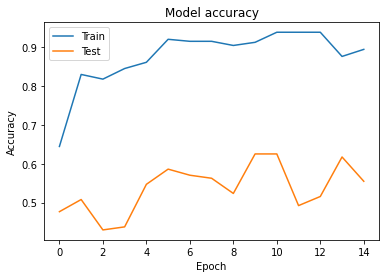

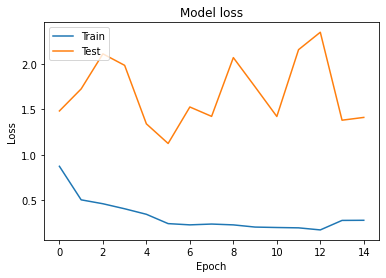

In [73]:
graph()

## Fine Tuning

In [74]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [75]:
# Unfreeze the last three inception modules
for layer in model.layers[:229]:
    layer.trainable = False
for layer in model.layers[229:]:
    layer.trainable = True

In [57]:
# Compile the model
from tensorflow.keras.optimizers import SGD

# optimizer with slow learning rate
model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [58]:
#Save the model
checkpointer = ModelCheckpoint('saved_model/fine_tuning.hdf5.hdf5', verbose=1,save_best_only=True,monitor='val_loss')
stopper = EarlyStopping(monitor='val_loss,val_acc',min_delta=0.1,patience=2,verbose=1,mode='auto')

In [76]:
# Train the model
history = model.fit_generator(train_generator, steps_per_epoch = 13,validation_data=valid_generator,validation_steps=3, epochs=15,verbose=1,callbacks=[checkpointer])

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 0.1973 - accuracy: 0.9197
Epoch 00001: val_loss did not improve from 1.12548
13/13 [==============================] - 26s 2s/step - loss: 0.1973 - accuracy: 0.9197 - val_loss: 1.4522 - val_accuracy: 0.6250
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9508
Epoch 00002: val_loss did not improve from 1.12548
13/13 [==============================] - 25s 2s/step - loss: 0.1441 - accuracy: 0.9508 - val_loss: 1.9926 - val_accuracy: 0.5625
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 0.1986 - accuracy: 0.9326
Epoch 00003: val_loss did not improve from 1.12548
13/13 [==============================] - 25s 2s/step - loss: 0.1986 - accuracy: 0.9326 - val_loss: 1.4450 - val_accuracy: 0.6042
Epoch 4/15
13/13 [==============================] - ETA: 0s - loss: 0.1447 - accuracy: 0.9567
Epoch 00004: val_loss did not improve from 1.12548
13/13 [==========================

## Prediction Function

In [78]:
# Load the weights fromt the fine-tuned model
# model.load_weights('saved_model/fine_tuning.hdf5.hdf5')

In [110]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
%matplotlib inline
def pred(path):
    t_img = image.load_img(path, target_size=(220,220))
    img = plt.imshow(t_img)
    x = img_to_array(t_img) #Convert the image to array
    x = np.expand_dims(x,axis=0) #Convert the array to the form (1,x,y,z) 
    x = preprocess_input(x) # Use the preprocess input function o subtract the mean of all the images
    p = np.argmax(model.predict(x)) # Store the argmax of the predictions
    if p==0:     # P=0 for basal,P=1 for melanoma , P=2 for squamous
        print("melanoma")
    elif p==1:
        print("scc")
    elif p==2:
        print("vas")
        
        
#     t_img=np.expand_dims(t_img,axis=0)
#     result = model.predict(t_img)
#     prediction = result[0]
#     classes=train_generator.class_indices
#     prediction=list(prediction)
#     classes=['malignant','squamous cell carcinoma','vascular lesion']
#     print(classes, prediction)
#     output=zip(classes,prediction)
#     output=dict(output)
    
#     if output["malignant"] == 1.0:
#         print("Melanoma")
#     elif output["squamous cell carcinoma"] ==1.0:
#         print("squamous cell carcinoma")
#     else:
#         print("vascular lesion")

melanoma


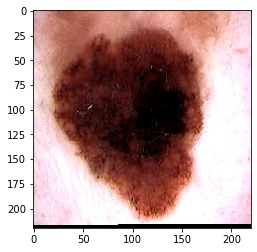

In [111]:
pred('data\Test\malignant\ISIC_4523382.jpg')

melanoma


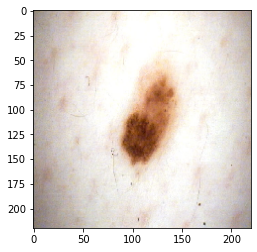

In [112]:
pred("data/Test/malignant/ISIC_8838753.jpg")

melanoma


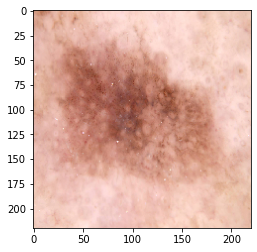

In [113]:
pred("data/Test/squamous cell carcinoma/ISIC_0024843.jpg")

melanoma


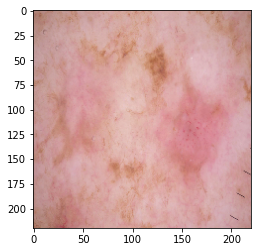

In [114]:
pred("data/Test/squamous cell carcinoma/ISIC_0025808.jpg")

vas


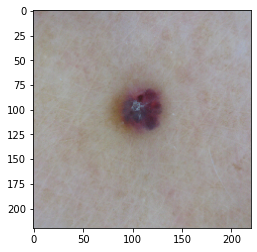

In [115]:
pred("data/Test/vascular lesion/ISIC_0070899.jpg")

vas


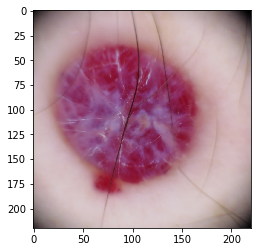

In [116]:
pred("data/Test/vascular lesion/ISIC_0065784.jpg")

In [117]:
# training metrics values
display(history.history)

{'loss': [0.19729888439178467,
  0.14410383999347687,
  0.19862651824951172,
  0.1447191834449768,
  0.17907361686229706,
  0.22410745918750763,
  0.17360819876194,
  0.1209837943315506,
  0.16077293455600739,
  0.16368579864501953,
  0.16912192106246948,
  0.1359635591506958,
  0.19441036880016327,
  0.17498905956745148,
  0.1742025911808014],
 'accuracy': [0.9196891188621521,
  0.9507771730422974,
  0.9326424598693848,
  0.9567307829856873,
  0.9326424598693848,
  0.909326434135437,
  0.9230769276618958,
  0.9559585452079773,
  0.9447115659713745,
  0.9378238320350647,
  0.9455958604812622,
  0.9350961446762085,
  0.9352331757545471,
  0.9300518035888672,
  0.9350961446762085],
 'val_loss': [1.4521937370300293,
  1.9926303625106812,
  1.4450191259384155,
  1.9664136171340942,
  1.2386412620544434,
  1.5479540824890137,
  1.6822773218154907,
  1.1935583353042603,
  2.178934097290039,
  1.3430237770080566,
  1.9696578979492188,
  1.6722116470336914,
  1.5650476217269897,
  2.5641252994

In [118]:
# graph
def plot_training(history):
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs  = range(len(acc))
    
    plt.plot(epochs,acc,'b')
    plt.plot(epochs,val_acc,'r')
    plt.title("Training and validation accuracy")
    
    plt.figure()
    plt.plot(epochs,loss,'b')
    plt.plot(epochs,val_loss,'r')
    plt.title("Training and validation loss")
    
    plt.show()

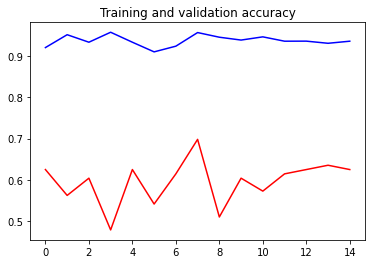

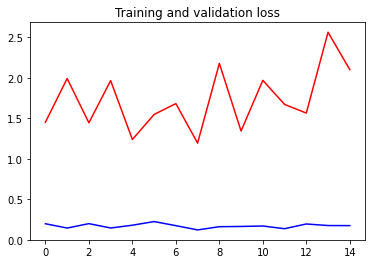

In [119]:
plot_training(history)